In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator
from scipy.optimize import minimize
import scipy.signal as sig
from scipy.optimize import least_squares, minimize

import time
from tqdm.notebook import trange
import importlib

#from sklearn.metrics import mean_absolute_error

from numpy import linalg as la

import copy

import sys
from importlib import reload,import_module
import os

#import sagemaker
#import boto3

%matplotlib inline

import copy
import random
import gym

import torch
import torch.nn as nn
from torch.autograd import Variable
#from sources.utilities.model_LTI_v2 import *
#from sources.utilities.utility_functions import *

In [2]:
env = gym.make("MountainCarContinuous-v0")

### Transition Dynamics
Given an action, the mountain car follows the following transition dynamics:
    
    

$$ velocity_{t+1} = velocity_t + (action - 1) * force - cos(3 * position_t) * gravity $$

$$ position_{t+1} = position_t + velocity_{t+1} \\
= position_t + velocity_t + (action - 1) * force - cos(3 * position_t) * gravity
$$

### learning the causal structure

In [3]:
class ModelNN(nn.Module):

    def __init__(self, state_size, action_size, num_hidden_layers, size__hidden_layer = 200, bias=True):
        super().__init__()
        layer = []
        input_size = state_size + action_size
        for i in range(num_hidden_layers):
            layer.append(nn.Linear(input_size, size__hidden_layer, bias=bias))
            layer.append(nn.ReLU())
            input_size = size__hidden_layer
        layer.append(nn.Linear(size__hidden_layer, state_size, bias=bias))
        self.net = nn.Sequential(*layer)

    def forward(self, S, A):
        
        # Concatenate the input and output of each block on the channel
        # dimension
        X = torch.cat((S, A), dim=1)
        #print(X)
        
        return self.net(X) #S + 

In [4]:
class ModelCon(nn.Module):

    def __init__(self, state_size, action_size):
        super().__init__()
        self.net = nn.Linear(state_size + action_size, state_size)

    def forward(self, S, A):
        
        # Concatenate the input and output of each block on the channel
        # dimension
        X = torch.cat((S, A), dim=1)
        
        return self.net(X) #S + 

In [5]:
model = ModelNN(2, 1, 3, bias=True)
#ModelCon(2, 1)
model.forward(torch.tensor([[-0.4502,  0.0000]]), torch.tensor([[-1.5406]]))

tensor([[0.0009, 0.0013]], grad_fn=<AddmmBackward0>)

In [6]:
model

ModelNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)

In [7]:
class DynamicDataset(torch.utils.data.IterableDataset):
    def __init__(self):
        super(DynamicDataset).__init__()
         
    def __iter__(self):
        env = gym.make("MountainCarContinuous-v0")
        #DumbEnv()
        #gym.make('MountainCar-v0')
        #action = env.action_space.sample()
        #print(action)
        done=True
        while True:
            if done:
                observation = env.reset()
            #env.render()
            action = env.action_space.sample()
            action = np.clip(action, -1.0, 1.0)
            #print(observation)
            next_observation, reward, done, info = env.step(action)
            #print(torch.tensor([observation]).shape)
            observation_tensor = torch.tensor([observation]).float()
            action_tensor = torch.tensor([action]).float()
            next_observation_tensor = torch.tensor([next_observation]).float()
            
            yield observation_tensor, action_tensor, 1000.0*(next_observation_tensor - observation_tensor)
            observation = next_observation


dataset = iter(DynamicDataset())
#dataloader = torch.utils.data.DataLoader(dataset, num_workers=1, batch_size=2)
print(next(dataset))
print(next(dataset))

(tensor([[-0.5443,  0.0000]]), tensor([[0.3807]]), tensor([[0.7259, 0.7259]]))
(tensor([[-0.5435,  0.0007]]), tensor([[-0.2692]]), tensor([[ 0.4716, -0.2543]]))


/home/agardille/.conda/envs/carla_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)


In [8]:
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), 0.01)
#optimizer_ft = torch.optim.Adam(car_detector.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [9]:
dataset = iter(DynamicDataset())
from torch.utils.tensorboard import SummaryWriter
def train_model(model, dataset, criterion, optimizer, scheduler, num_epochs=25):
    writer = SummaryWriter('tensorboard/model_learning')
    since = time.time()

    pbar = trange(num_epochs)
    for epoch in pbar:
        running_loss = 0.0
        for _ in range(1000):
            state, action, label = next(dataset)
            #print(state, action, label)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                output = model(state, action)
                #print(state, action, label, output)
                loss = criterion(output, label)

                #print('outputs: ', outputs)
                #print('labels: ', labels)
                #print('loss: ', loss)
                #print()

                loss.backward()
                optimizer.step()

                # statistics
            running_loss += loss.item() 
            
            #pbar.set_description("state: " + str(state) + " , action: " + str(action) +", label: " + str(label))

        scheduler.step()

        epoch_loss = running_loss  / 1000

        print(f'Loss: {epoch_loss:.4f}')
        print()

        # deep copy the model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        writer.add_scalar(f' Loss', epoch_loss, epoch)
        writer.flush()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model
    
train_model(model, dataset, criterion, optimizer, scheduler, num_epochs=25)
     

  0%|          | 0/25 [00:00<?, ?it/s]

Loss: 27.5871


Loss: 57.3134


Loss: 136.5687


Loss: 68.5666


Loss: 11.9045


Loss: 36.6773


Loss: 56.2178


Loss: 7.0319


Loss: 2.8823


Loss: 1.6342


Loss: 1.1863


Loss: 1.2194


Loss: 1.1790


Loss: 1.2529


Loss: 1.8011


Loss: 0.5717


Loss: 0.6292


Loss: 1.8327


Loss: 0.4598


Loss: 0.4968


Loss: 0.5421


Loss: 0.9559


Loss: 1.0090


Loss: 0.7136


Loss: 0.9826


Training complete in 0m 33s


ModelNN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)

  0%|          | 0/1000 [00:00<?, ?it/s]

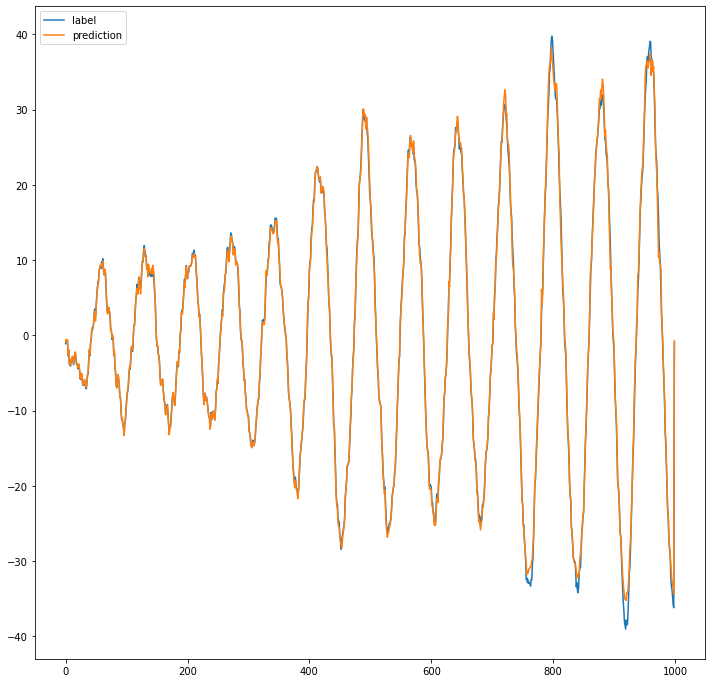

In [10]:
dataset = iter(DynamicDataset())

#columns = ['Position', 'Velocity', 'Angle','Angular Velocity']

pbar = trange(1000)
labels = []
preds = []
inputs = []
done=True
for _ in pbar:
    state, action, label = next(dataset)
    
    #observation_tensor = torch.tensor(observation).float()
    #action_tensor = torch.tensor([action]).float()[None,:]
    #print(observation_tensor, action_tensor)
    pred = model(state, action).detach() #.numpy()
    #print(state, action, label, pred)
    preds.append(pred[0].numpy())
    labels.append(label[0].numpy())
    inputs.append(action[0].numpy())
    
   
inputs = np.array(inputs)
labels = np.array(labels)

preds = np.array(preds)

for i, label in enumerate(['position']): #, 'velocity']):
    plt.figure(figsize=(12, 12))
    plt.plot(labels[:,i], label = 'label')
    plt.plot(preds[:,i], label = 'prediction')
    plt.legend()
    
    plt.show()

env.close()

observation = env.reset()

#columns = ['Position', 'Velocity', 'Angle','Angular Velocity']

pbar = trange(100)
labels = []
preds = []
inputs = []
done=True
for _ in pbar:
    if done:
        observation = env.reset()
        action = env.action_space.sample()
    #env.render()
    
    #print(action)

    next_observation, reward, done, info = env.step(action)
    pbar.set_description(str(observation))
    #print(observation)
    labels.append(next_observation)
    inputs.append(observation)
    
    observation_tensor = torch.tensor([observation]).float()
    action_tensor = torch.tensor([action]).float() #[None,:]
    print(observation_tensor, action_tensor)
    pred = model(observation_tensor, action_tensor)[0].detach().numpy()
    preds.append(pred)
    
    observation = next_observation
   
inputs = np.array(inputs)
labels = np.array(labels)

preds = np.array(preds)

for i, label in enumerate(['position']): #, 'velocity']):
    plt.plot(labels[:,i], label = 'label')
    plt.plot(preds[:,i], label = 'prediction')
    plt.legend()
    plt.show()

env.close()